In [18]:
import math
import multiprocessing as mg
import multiprocessing.pool
# import pys2let as ps
import random
import string
import itertools
import os

import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav
import matplotlib.pyplot as plt
%matplotlib inline 
import skyclean
from skyclean import CMB_data

In [4]:
def mw_alm_2_hp_alm(MW_alm, lmax):
    '''MW_alm: 2D array of shape (Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
    '''
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
        
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]

    return hp_alm


def Single_Map_doubleworker(MW_Pix_Map):
    '''
    Input: MW_Pix_Map: list of mw maps at different scales 
    Each pixel map is a wavelet pixel map of shape (1, Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
    It is the output of s2wav.analysis
    (Scale: 0, size (1, 4, 7))

    Process:
    1. Covert MW Pixel Map to MW alm space using s2fft.forward

    2. Add zero to the mw alms  (Is it correct? or should I add zeros to the hp alm's and then convert to mw alm's)
    by adding zeros to the MW alm's we are increasing the resolution of the map
    Double the rows of the mw alms, since, the number of rows represents the L (level of detail)
    
    3. Convert mw alm to mw map 
    
    '''
    # print("original Pixel Map size", MW_Pix_Map.shape)
    MW_alm = s2fft.forward(MW_Pix_Map, L = MW_Pix_Map.shape[1])
    # print("original alm size", MW_alm.shape)
    
   
    # print("Scale:",i,"original alm size", MW_alm[i].shape)
    padded_alm = np.zeros((MW_alm.shape[0]*2,MW_alm.shape[1]*2))
    # stored_wavelet_coeffs_alm_doubled.append(skyclean.double_resolution(stored_wavelet_coeffs_alm[i]))
    padded_alm[:MW_alm.shape[0], :MW_alm.shape[1]] = MW_alm
    # print("padded alm size", padded_alm.shape)
    MW_alm_doubled = padded_alm
    
    MW_Pix_Map_doubled = s2fft.inverse(MW_alm_doubled, L = MW_alm_doubled.shape[0])
    # print("Scale:","doubled map size", MW_Pix_Map_doubled.shape)

    return MW_Pix_Map_doubled


def smoothed_covariance(MW_Map1, MW_Map2):
    '''
    Input: MW_Map1, MW_Map2: same size MW pixel wavelet maps at different frequencies
    output: R_map: smoothed covariance map beteen MW_Map1 and MW_Map2
    '''
    smoothing_lmax = MW_Map1.shape[0]
    # Get the real part of the map
    map1 = np.real(MW_Map1)
    map2 = np.real(MW_Map2)
    # Covariance matrix
    R_MW_Pixel_map = np.multiply(map1,map2) + 0.j #Add back in zero imaginary part
    # print("R", R_MW_Pixel_map.shape)

    # smoothing in harmonic space for efficiency
    R_MW_alm = s2fft.forward(R_MW_Pixel_map, L = smoothing_lmax)
    # print("R_MW_alm", R_MW_alm.shape)


    nsamp = 1200.0
    lmax_at_scale_j = R_MW_alm.shape[0]
    npix = hp.nside2npix(1<<(int(0.5*lmax_at_scale_j)-1).bit_length())
    # (int(0.5*scale_lmax)-1).bit_length() calculates the number of bits necessary to represent the integer int(0.5*scale_lmax)-1 in binary.
    # 1 << (int(0.5*scale_lmax)-1).bit_length() performs a bitwise left shift, essentially calculating 2^(number of bits).
    scale_fwhm = 4.0 * math.sqrt(nsamp / npix)
    # for high resolution maps, it is still the same number pixels sampled by the actual range is smaller.
    # the beam will become very narrow.


    gauss_smooth = hp.gauss_beam(scale_fwhm,lmax=smoothing_lmax-1)
    MW_alm_beam_convolved = np.zeros(R_MW_alm.shape, dtype=np.complex128)

    # Convolve the MW alms with the beam
    for i in range(R_MW_alm.shape[1]):
        MW_alm_beam_convolved[:, i] = R_MW_alm[:, i] * gauss_smooth
    
    R_covariance_map = s2fft.inverse(MW_alm_beam_convolved, L = smoothing_lmax)

    return R_covariance_map




 

## Loaded mw wavelet coefficient map
stored_wavelet_coeffs_pix = [np.load(f"../convolution/wavelet_coefficient/wav_30_{i}.npy", allow_pickle=True) for i in range(12)]
stored_scaling_coeffs_pix = np.load("../convolution/scaling_coefficient/scal_30.npy")


# print(stored_wavelet_coeffs_pix[0].shape)
stored_wavelet_coeffs_pix = stored_wavelet_coeffs_pix[:3]

wavelet_MW_Pix_Map_doubled = Single_Map_doubleworker(stored_wavelet_coeffs_pix[0])

# display(wavelet_MW_Pix_Map_doubled[0])
# Why oen dimension is reduced?
# Is it the spin?
print(wavelet_MW_Pix_Map_doubled.shape)


R_covariance_map = smoothed_covariance(wavelet_MW_Pix_Map_doubled, wavelet_MW_Pix_Map_doubled)

R_covariance_map.shape

(8, 15)


(8, 15)

In [60]:
# smoothed_covariance(wavelet_MW_Pix_Map_doubled, wavelet_MW_Pix_Map_doubled)[0][0]

(1.9514297468690185e-11-4.36429717423837e-29j)

In [5]:
# we don't want to store all the data in a dictionary 
# wavelet is wavelet, and alm is alm 
# we get them from the same function

import numpy as np

def load_frequency_data(base_path, file_template, frequencies, scales=None):
    """
    Load NumPy arrays from dynamically generated file paths for each frequency and scale.
    
    Args:
        base_path (str): The base path where the files are located.
        file_template (str): The template for the file names, with placeholders for frequency and scale.
        frequencies (list): A list of frequency names.
        scales_: A lists of scales.
        
    Returns:
        dict: A dictionary where keys are tuples of (frequency, scale) and values are loaded NumPy arrays.
    """
    frequency_data = {}
    for frequency in frequencies:
        for scale in scales:
            # Generate the file path using the template and the current frequency and scale
            path = f"{base_path}/{file_template.format(frequency, scale)}"
            try:
                frequency_data[(frequency, scale)] = np.load(path, allow_pickle=True)
            except Exception as e:
                print(f"Error loading {path} for frequency {frequency} and scale {scale}: {e}")
    return frequency_data



base_path = "../convolution/wavelet_coefficient"
file_template = "wav_{}_{}.npy"
frequencies = ['030', '070']
scales = [0, 1, 2]

original_wavelet_c_j = load_frequency_data(base_path, file_template, frequencies, scales)

# for (frequency, scale), data in frequency_data.items():
#     print(f"Frequency: {frequency}, Scale: {scale}, Data shape: {data.shape}")




In [6]:
for i in frequencies:
    for j in scales:
        # print(frequency_data[(i,j)].shape)
        wavelet_MW_Pix_Map_doubled = Single_Map_doubleworker(original_wavelet_c_j[(i,j)])
        np.save(f"../convolution/wavelet_coefficient_doubled/wav_{i}_{j}.npy", wavelet_MW_Pix_Map_doubled)

In [8]:

doubled_MW_wav_c_j = load_frequency_data("../convolution/wavelet_coefficient_doubled", "wav_{}_{}.npy", frequencies, scales)
print(doubled_MW_wav_c_j.keys())


dict_keys([('030', 0), ('030', 1), ('030', 2), ('070', 0), ('070', 1), ('070', 2)])


In [9]:
import numpy as np

def calculate_covariance_matrix(frequencies, doubled_MW_wav_c_j,scales):
    """
    Calculates the covariance matrices for given frequencies and saves them to disk,
    accommodating any size of the input data arrays.
    
    Args:
    frequencies (list): List of frequency indices.
    doubled_MW_wav_c_j (dict): Dictionary containing data arrays for covariance calculations.
    """
    # Check dimensions of the first item to set the size of the covariance matrices
    if frequencies:
        sample_data = doubled_MW_wav_c_j[(frequencies[0], scale)]
        n_rows, n_cols = sample_data.shape
    else:
        raise ValueError("Frequency list is empty.")
    
    total_frequency = len(frequencies)
    # Initialize a 4D array to store the covariance matrices
    full_array = np.zeros((total_frequency, total_frequency, n_rows, n_cols), dtype=np.complex128)

    # Calculate the covariance matrix and save each one
    for i in range(total_frequency):
        for fq in range(i, total_frequency):
            print(f"Calculating covariance between {frequencies[i]} and {frequencies[fq]}")
            
            full_array[i, fq] = smoothed_covariance(doubled_MW_wav_c_j[(frequencies[i], scale)],
                                                    doubled_MW_wav_c_j[(frequencies[fq], scale)])
            # Save the computed covariance matrix
            np.save(f"../convolution/covariance_matrix/cov_{scale}_{frequencies[i]}_{frequencies[fq]}.npy", full_array[i, fq])
    
    # Fill the symmetric part of the matrix
    for l1 in range(1, total_frequency):
        for l2 in range(l1):
            full_array[l1, l2] = full_array[l2, l1]
    return full_array
scale = 0
R = calculate_covariance_matrix(frequencies, doubled_MW_wav_c_j,scale)


Calculating covariance between 030 and 030
Calculating covariance between 030 and 070
Calculating covariance between 070 and 070


In [10]:
import numpy as np

def process_and_save_matrices(R):
    """
    Processes the given 4D matrix R by computing and saving the weight vectors for each matrix in the first two dimensions.
    Also stores results in memory as arrays and saves them to disk. Adjusts the size of the identity vector based on sub-matrix size.

    Args:
    R (np.ndarray): A 4D matrix with dimensions suitable for swapping and inverting.

    Returns:
    np.ndarray, np.ndarray: Arrays containing the inverse matrices and weight vectors.
    """
    # Swap the axes to get R_Pix
    R_Pix = np.swapaxes(np.swapaxes(R, 0, 2), 1, 3)
    
    # Get dimensions for looping and size of sub-matrices
    dim1, dim2, subdim1, subdim2 = R_Pix.shape
    print(dim1, dim2, subdim1, subdim2)
    # Create arrays to store inverses and weight vectors
    inverses = np.zeros((dim1, dim2, subdim1, subdim2), dtype=np.complex128)
    weight_vectors = np.zeros((dim1, dim2, subdim1), dtype=np.complex128)
    
    # Adjust identity vector size based on sub-matrix dimensions
    identity_vector = np.ones(subdim2, dtype=float)
    
    for i in range(dim1):
        for j in range(dim2):
        
            # Invert the matrix at position (i, j)
            inverses[i, j] = np.linalg.inv(R_Pix[i, j])
            
            # Compute the weight vector
            numerator = np.dot(inverses[i, j], identity_vector)
            denominator = np.dot(np.dot(inverses[i, j], identity_vector),identity_vector)
            weight_vectors[i, j] = numerator / denominator
            
            # Save the inverse matrix and weight vector to disk
            # np.save(f"../weight_vector_data/inverse_matrix_{i}_{j}.npy", inverses[i, j])
            # np.save(f"../weight_vector_data/weight_vector_{i}_{j}.npy", weight_vectors[i, j])
    np.save(f"../weight_vector_data/weight_vector.npy", weight_vectors)
            

    return inverses, weight_vectors

# Example usage
# R = np.random.rand(4, 4, 2, 2) + 1j * np.random.rand(4, 4, 2, 2)  # Example 4D matrix with complex numbers
inverses, weight_vectors = process_and_save_matrices(R)

print("Inverse Matrices Shape:", inverses.shape)
print("Weight Vectors Shape:", weight_vectors.shape)


8 15 2 2
Inverse Matrices Shape: (8, 15, 2, 2)
Weight Vectors Shape: (8, 15, 2)


In [12]:
print(doubled_MW_wav_c_j.keys())

dict_keys([('030', 0), ('030', 1), ('030', 2), ('070', 0), ('070', 1), ('070', 2)])


In [14]:
double_30 = doubled_MW_wav_c_j[(frequencies[0], 0)]
double_70 = doubled_MW_wav_c_j[(frequencies[1], 0)]

doubled_map = np.zeros((double_30.shape[0],double_30.shape[1]), dtype=np.complex128)


for i in range(double_30.shape[0]):
    for j in range(double_30.shape[1]):
        pix_vector = np.array([double_30[i,j],double_70[i,j]])
        # print(double_30[i,j],double_70[i,j])
        # print(pix_vector.shape)
        doubled_map[i,j] = np.dot(weight_vector_load[i,j],pix_vector)


In [21]:
def mw_alm_2_hp_alm(MW_alm, lmax):
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]
    
    return hp_alm

def trim_alm_to_original(MW_alm_doubled, original_shape):
    '''
    Input:
        MW_alm_doubled: The alm array with increased resolution.
        original_shape: A tuple indicating the original size of the alm data.

    Process:
        1. Trim the alm array back to its original dimensions.
        2. Convert the trimmed alm array back to a pixel map using an inverse spherical transform.

    Returns:
        MW_Pix_Map_original: The pixel map converted back to its original resolution.
    '''
    # Extract the original size part from the doubled alm data
    trimmed_alm = MW_alm_doubled[:original_shape[0], :original_shape[1]]

    # Convert trimmed alm to the original pixel map
    MW_Pix_Map_original = s2fft.inverse(trimmed_alm, L=original_shape[0])

    return MW_Pix_Map_original

In [67]:
original_wavelet_c_j
original_30 = original_wavelet_c_j[(frequencies[0], 0)]
original_70 = original_wavelet_c_j[(frequencies[1], 0)]

In [36]:
original_30.shape

(1, 4, 7)

In [68]:
# stored_wavelet_coeffs_pix[0]
# Lmax = stored_wavelet_coeffs_pix[0].shape[1]


L_max = original_70.shape[0]
original_map_alm = s2fft.forward(original_70, L = L_max)
print(original_map_alm.shape)
original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm, L_max-1)
original_hp_map = hp.alm2map(original_map_hp_alm, nside=L_max-1)

hp.mollview(
            original_hp_map*1e5,
            coord=["G"],
            title="Wavelet Coefficient Map at Scale ",
            unit=r"$1e5$K",
            # min=-1, 
            # max=1,
        )




L_max = double_70.shape[0]
original_map_alm = s2fft.forward(double_70, L = L_max)
print(original_map_alm.shape)
original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm, L_max-1)
original_hp_map = hp.alm2map(original_map_hp_alm, nside=L_max-1)

hp.mollview(
            original_hp_map*1e5,
            coord=["G"],
            title="Wavelet Coefficient Map at Scale ",
            unit=r"$1e5$K",
            # min=-1, 
            # max=1,
        )

trimmed_map = trim_alm_to_original(double_70, [4,7])
doubled_map_alm = s2fft.forward(trimmed_map, L = trimmed_map.shape[0])
print(doubled_map_alm.shape)
doubled_map_hp_alm = mw_alm_2_hp_alm(doubled_map_alm, trimmed_map.shape[0]-1)
doubled_hp_map = hp.alm2map(doubled_map_hp_alm, nside=trimmed_map.shape[0]-1)
hp.mollview(
            doubled_hp_map*1e5,
            coord=["G"],
            title="Wavelet Coefficient Map at Scale ",
            unit=r"$1e5$K",
            # min=-1, 
            # max=1,
        )

IndexError: index 1 is out of bounds for axis 0 with size 1

(4, 7)


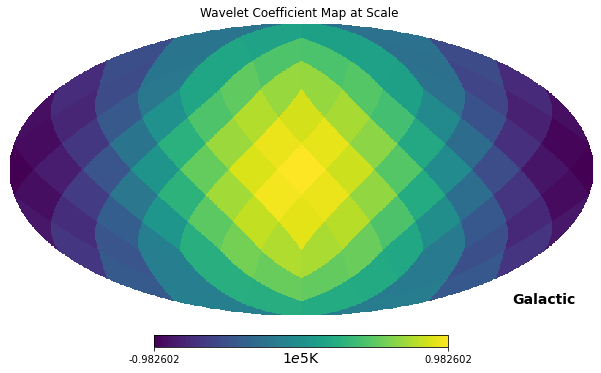

In [61]:
stored_wavelet_coeffs_pix[0]
Lmax = stored_wavelet_coeffs_pix[0].shape[1]
L_max = original_70.shape[0]
original_map_alm = s2fft.forward(original_70, L = Lmax)
print(original_map_alm.shape)
original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm, Lmax-1)
original_hp_map = hp.alm2map(original_map_hp_alm, nside=Lmax-1)

hp.mollview(
            original_hp_map*1e5,
            coord=["G"],
            title="Wavelet Coefficient Map at Scale ",
            unit=r"$1e5$K",
            # min=-1, 
            # max=1,
        )

In [40]:
stored_wavelet_coeffs_pix[0].shape

(1, 4, 7)

In [59]:

# for i in [0,1,2,3,4,5,6,7,8,9,10,11]:

#     wavelet_healpix_map = np.load(f"../convolution/wavelet_healpix_map_{i}_030_1.npy") 
#     wavelet_scale = str(i+1)
#     hp.mollview(
#             wavelet_healpix_map*1e5,
#             coord=["G"],
#             title="Wavelet Coefficient Map at Scale "+wavelet_scale,
#             unit=r"$1e-5$K",
#             # min=-1, 
#             # max=1,
#         )

In [60]:
trimmed_map = trim_alm_to_original(doubled_map, [4,7])


doubled_map_alm = s2fft.forward(trimmed_map, L = trimmed_map.shape[0])
print(doubled_map_alm.shape)
doubled_map_hp_alm = mw_alm_2_hp_alm(doubled_map_alm, trimmed_map.shape[0]-1)
doubled_hp_map = hp.alm2map(doubled_map_hp_alm, nside=trimmed_map.shape[0]-1)

(4, 7)


In [100]:
trimmed_map = trim_alm_to_original(double_30, [4,7])


doubled_map_alm = s2fft.forward(trimmed_map, L = trimmed_map.shape[0])
print(doubled_map_alm.shape)
doubled_map_hp_alm = mw_alm_2_hp_alm(doubled_map_alm, trimmed_map.shape[0]-1)
doubled_hp_map = hp.alm2map(doubled_map_hp_alm, nside=trimmed_map.shape[0]-1)

(4, 7)


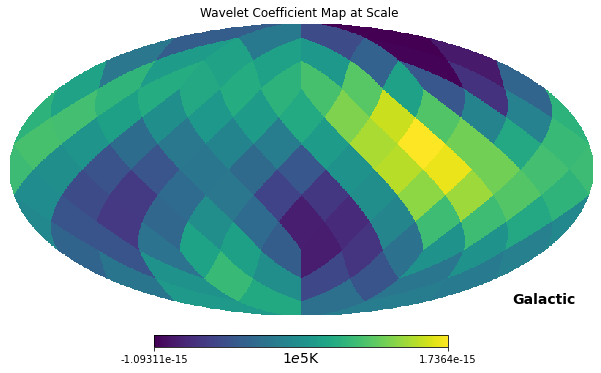

In [101]:
hp.mollview(
            doubled_hp_map*1e5,
            coord=["G"],
            title="Wavelet Coefficient Map at Scale ",
            unit=r"$1e5$K",
            # min=-1, 
            # max=1,
        )